<a href="https://colab.research.google.com/github/lnrdmnc/NER-NLP/blob/main/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 972.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 2.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.10.0
    Uninstalling typing_extensions-4.10.0:
      Successfully uninstalled typing_extensions-4.10.0
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.15.1
    Uninstalling 

In [ ]:
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 12.4 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=83d90447aa621b71d6aef76f3ace3cb6411abda1b03d1333b4a1c42dbd083750
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import os  # Importa il modulo per interagire con il sistema operativo
import shutil  # Importa il modulo per operazioni di alto livello sui file

import tensorflow as tf  # Importa TensorFlow, un framework per machine learning
import tensorflow_hub as hub  # Importa TensorFlow Hub per moduli pre-addestrati
import tensorflow_text as text  # Importa TensorFlow Text per il trattamento del testo
from official.nlp import optimization  # Importa modulo per AdamW optimizer

import matplotlib.pyplot as plt  # Importa Matplotlib per la visualizzazione dei dati

tf.get_logger().setLevel('ERROR')  # Imposta il livello di log a 'ERROR' in TensorFlow

In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 4s 0us/step


Utilizzeremo text_dataset_from_directory per creare un tf.data.Dataset etichettato.

Il set di dati IMDB è già stato suddiviso in training e test, ma manca un set di convalida.
Creiamo un set di convalida utilizzando una suddivisione 80:20 dei dati di training utilizzando l'argomento validation_split riportato di seguito.
quando si utilizzano gli argomenti validation_split e subset, assicurarsi di specificare un seme casuale o di passare shuffle=False, in modo che le suddivisioni di convalida e addestramento non si sovrappongano

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Test delle recensioni

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

# Caricamento di modelli da TensorFlow Hub

Per caricare modelli BERT da TensorFlow Hub e perfezionarli, puoi scegliere tra diverse opzioni:

## Modelli BERT Disponibili:
1. **Base BERT**: Include modelli come il BERT senza custodia e altri sette modelli con pesi addestrati dagli autori originali.
2. **Piccoli BERT**: Offrono la stessa architettura generale di BERT ma con meno e/o blocchi Transformer più piccoli per esplorare compromessi tra velocità, dimensioni e qualità.
3. **ALBERT**: Offre quattro dimensioni diverse di "A Lite BERT" che riducono le dimensioni del modello condividendo i parametri tra i livelli.
4. **Esperti BERT**: Forniscono otto modelli con l'architettura base BERT ma con variazioni per diversi domini di pre-formazione.
5. **Electra**: Simile a BERT ma pre-addestrato come discriminatore in una configurazione simile a una GAN.
6. **BERT con Talking-Heads Attenzione e GELU recintato**: Offre miglioramenti al nucleo dell'architettura Transformer.

## Suggerimenti per la Scelta del Modello:
- Inizia con un BERT piccolo per una messa a punto più veloce.
- Se desideri un modello piccolo con maggiore precisione, considera ALBERT.
- Per una precisione superiore, opta per le classiche dimensioni BERT o per i recenti perfezionamenti come Electra, Talking Heads o Esperti BERT.

## Ulteriori Risorse:
- Esistono anche versioni più grandi dei modelli che offrono una maggiore precisione ma potrebbero richiedere risorse più elevate.
- Per attività più complesse, puoi utilizzare i modelli su una collaborazione TPU seguendo le istruzioni fornite.

Per provare diversi modelli, è sufficiente modificare l'URL tfhub.dev nel codice, poiché le differenze sono gestite nei SavedModels di TF Hub. Segui i link forniti per ulteriori dettagli e riferimenti alla letteratura di ricerca.


In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


# **Preprocessing model**

Il modello di preprocessing associato ai modelli BERT forniti da TensorFlow Hub è essenziale per trasformare gli input di testo in identificatori numerici di token e organizzarli in diversi Tensor prima di essere inseriti in BERT. Questo modello di preprocessing, implementato utilizzando TF ops dalla libreria TF.text, è fondamentale per preparare i dati in modo compatibile con l'architettura dei modelli BERT.

È importante notare che il modello di preprocessing corretto è quello menzionato nella documentazione del modello BERT specifico che stai utilizzando. Questo modello di preprocessing è selezionato automaticamente quando si carica il modello BERT tramite TensorFlow Hub, garantendo una corretta trasformazione dei dati testuali in input numerici per il modello BERT.

Per caricare correttamente il modello di preprocessing insieme al modello BERT per ottimizzazioni ulteriori, è consigliabile utilizzare hub.KerasLayer, che rappresenta l'API preferita per caricare un SavedModel TF2-style da TF Hub in un modello Keras.

Se hai bisogno di ulteriori dettagli o chiarimenti sulla selezione e l'utilizzo del modello di preprocessing specifico per un determinato modello BERT, ti invito a consultare la documentazione ufficiale del modello BERT che stai utilizzando tramite il link fornito sopra.

Citations:
[1] https://www.tensorflow.org/hub
[2] https://blog.tensorflow.org/2020/12/making-bert-easier-with-preprocessing-models-from-tensorflow-hub.html?m=1
[3] https://www.tensorflow.org/hub/tutorials/bert_experts
[4] https://cloud.google.com/blog/topics/developers-practitioners/add-preprocessing-functions-tensorflow-models-and-deploy-vertex-ai
[5] https://blog.tensorflow.org/2020/12/making-bert-easier-with-preprocessing-models-from-tensorflow-hub.html

### **BERT Preprocessing Model in Google Colab**

Il `bert_preprocess_model` rappresenta un layer di pre-elaborazione basato su BERT utilizzando TensorFlow Hub. Questo layer è fondamentale per preparare i dati in ingresso in modo da renderli compatibili con il modello BERT durante l'addestramento o l'inferenza.

Nel dettaglio, il layer di pre-elaborazione BERT si occupa delle seguenti operazioni:
- **Tokenizzazione del Testo**: Suddivide il testo in token significativi.
- **Conversione in ID Numerici**: Trasforma i token in ID numerici per la rappresentazione numerica del testo.
- **Aggiunta di Token Speciali**: Inserisce i token speciali come `[CLS]` e `[SEP]` richiesti da BERT.
- **Altre Trasformazioni**: Applica eventuali altre trasformazioni necessarie per adattare i dati al modello BERT.

Utilizzando questo layer di pre-elaborazione, è possibile preparare correttamente i dati testuali affinché possano essere elaborati in modo efficiente da un modello BERT. Questo processo è essenziale per compiti come classificazione del testo, analisi del sentiment o altre attività di elaborazione del linguaggio naturale (NLP) su Google Colab.**testo in grassetto**

Proviamo il modello di preelaborazione su del testo e vediamo l'output:

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

# Stampare le chiavi del dizionario restituito dal layer di pre-elaborazione
print(f'Keys       : {list(text_preprocessed.keys())}')

# Stampare la forma (shape) dell'input_word_ids
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')

# Stampare gli ID delle parole per i primi 12 token
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')

# Stampare la maschera di input per i primi 12 token
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')

# Stampare gli ID del tipo per i primi 12 token
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### **Output della Preelaborazione per un Modello BERT**
Dopo la preelaborazione, il modello BERT utilizzerebbe tre output principali:
input_word_ids: identificatori numerici dei token.

1.   input_mask: maschera di input per gestire la lunghezza variabile delle sequenze.
2.   input_type_ids: identificatori del tipo di input, che in questo caso hanno un solo valore (0) poiché si tratta di un input a frase singola.
3. Altri punti rilevanti includono:
L'input viene troncato a 128 token, ma questo numero può essere personalizzato.
Per ulteriori dettagli sull'utilizzo di BERT per risolvere le attività GLUE su TPU, consulta la sezione Solve GLUE tasks using BERT on TPU Text TensorFlow.

Gli input_type_ids contengono solo un valore (0) poiché l'input è una singola frase. Per input con più frasi, ci sarebbe un valore distinto per ciascuna.

Essendo un modello TensorFlow, questo preprocessore di testo può essere facilmente integrato direttamente nel modello.

## Utilizzando il modello BERT

Prima di inserire BERT nel tuo modello, diamo un'occhiata ai suoi risultati.
Lo caricherai da TF Hub e vedrai i valori restituiti.



In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_model = hub.KerasLayer(tfhub_handle_encoder) carica un modello BERT pre-addestrato utilizzando TensorFlow Hub e lo assegna alla variabile bert_model.

Questo modello BERT pre-addestrato può essere utilizzato per eseguire operazioni di elaborazione del linguaggio naturale (NLP) come classificazione del testo, analisi del sentiment, generazione di testo e altre attività NLP.

Utilizzando hub.KerasLayer, il modello BERT viene integrato come un layer all'interno di un modello Keras, consentendo di sfruttare le funzionalità di TensorFlow Hub per l'importazione e l'utilizzo semplice di modelli pre-addestrati come BERT all'interno di progetti di machine learning e deep learning.

In [ ]:
bert_results = bert_model(text_preprocessed)

# Stampa informazioni sui risultati ottenuti dall'elaborazione con il modello BERT
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape: {bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values: {bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape: {bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values: {bert_results["sequence_output"][0, :12]}')


Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape: (1, 512)
Pooled Outputs Values: [ 0.762629    0.99280983 -0.18611868  0.36673862  0.15233733  0.6550447
  0.9681154  -0.9486271   0.00216128 -0.9877732   0.06842692 -0.97630584]
Sequence Outputs Shape: (1, 128, 512)
Sequence Outputs Values: [[-0.28946346  0.3432128   0.33231518 ...  0.21300825  0.7102068
  -0.05771117]
 [-0.28742072  0.31981036 -0.23018576 ...  0.58455    -0.21329743
   0.72692114]
 [-0.66157067  0.68876773 -0.8743301  ...  0.1087725  -0.26173177
   0.47855407]
 ...
 [-0.2256118  -0.2892561  -0.0706445  ...  0.47566038  0.83277136
   0.40025333]
 [-0.2982428  -0.27473134 -0.05450517 ...  0.48849747  1.0955354
   0.18163396]
 [-0.44378242  0.00930811  0.07223688 ...  0.1729009   1.1833243
   0.07898017]]


I modelli BERT restituiscono una mappa con 3 chiavi importanti: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` rappresenta ogni sequenza di input nel suo complesso. La forma è [batch_size, H]. Puoi pensare a questo come un embedding per l'intera recensione del film.
- `sequence_output` rappresenta ogni token di input nel contesto. La forma è [batch_size, lunghezza_seq, H]. Puoi pensare a questo come un embedding contestuale per ogni token nella recensione del film.
- Gli `encoder_outputs` sono le attivazioni intermedie dei blocchi Transformer L. `outputs["encoder_outputs"][i]` è un tensore di forma [batch_size, lunghezza_seq, 1024] con le uscite dell'i-esimo blocco Transformer, per 0 <= i < L. L'ultimo valore della lista è uguale a `sequence_output`.
Per il fine-tuning, utilizzerai l'array `pooled_output`.

### **Definisci il tuo modello**

Creerai un modello molto semplice per il fine-tuning, utilizzando il modello di pre-elaborazione, il modello BERT selezionato, uno strato Dense e uno strato Dropout.

Nota: per ulteriori informazioni sull'input e l'output del modello di base, puoi seguire l'URL del modello per la documentazione. In questo caso specifico, non è necessario preoccuparsene poiché il modello di pre-elaborazione si occuperà di questo per te.

In [ ]:
def build_classifier_model():
    # Definizione dell'input per il testo
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Layer di pre-elaborazione basato su BERT
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

    # Elaborazione del testo attraverso il layer di pre-elaborazione
    encoder_inputs = preprocessing_layer(text_input)

    # Caricamento del modello BERT come encoder
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

    # Passaggio dei dati attraverso il modello BERT
    outputs = encoder(encoder_inputs)

    # Estrazione dell'output aggregato (pooled output) dal modello BERT
    net = outputs['pooled_output']

    # Applicazione di un layer di Dropout per la regolarizzazione
    net = tf.keras.layers.Dropout(0.1)(net)

    # Aggiunta di un layer Dense per la classificazione binaria senza attivazione
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)

    # Creazione del modello finale con input e output definiti
    return tf.keras.Model(text_input, net)


### Build Classifier Model

`build_classifier_model` che costruisce un modello di classificazione utilizzando BERT come encoder. Ecco una spiegazione dettagliata delle operazioni svolte all'interno della funzione:

1. Viene definito un input per il testo utilizzando `tf.keras.layers.Input`.
2. Viene aggiunto un layer di pre-elaborazione basato su BERT utilizzando `hub.KerasLayer`.
3. Il testo in input viene elaborato attraverso il layer di pre-elaborazione.
4. Viene caricato il modello BERT come encoder utilizzando `hub.KerasLayer`.
5. I dati vengono passati attraverso il modello BERT per ottenere gli output.
6. Viene estratto l'output aggregato (pooled output) dal modello BERT.
7. Viene applicato un layer di Dropout per la regolarizzazione.
8. Viene aggiunto un layer Dense per la classificazione binaria senza attivazione.
9. Infine, viene creato e restituito il modello finale con gli input e gli output definiti.

Questo codice rappresenta la costruzione di un modello di classificazione che utilizza BERT come parte integrante per l'elaborazione del testo e la generazione delle previsioni.

Verifichiamo che il modello venga eseguito con l'output del modello di preelaborazione.

In [ ]:
# Costruzione del modello di classificazione utilizzando BERT come encoder
classifier_model = build_classifier_model()

# Esecuzione del modello sul testo di esempio per ottenere i risultati grezzi da BERT
bert_raw_result = classifier_model(tf.constant(text_test))

# Applicazione della funzione di attivazione sigmoid per ottenere le previsioni finali
print(tf.sigmoid(bert_raw_result))


tf.Tensor([[0.36441654]], shape=(1, 1), dtype=float32)



1. Viene costruito il modello di classificazione utilizzando BERT come encoder tramite la funzione `build_classifier_model`.
2. Il modello viene eseguito sul testo di esempio `text_test` per ottenere i risultati grezzi generati da BERT.
3. Viene applicata la funzione di attivazione sigmoid a `bert_raw_result` per ottenere le previsioni finali del modello.

In sintesi, questo codice utilizza il modello di classificazione costruito con BERT per generare previsioni su un testo di esempio e applica la funzione di attivazione sigmoid per ottenere le probabilità associate alle classi di output.

L'output non ha significato, ovviamente, perché il modello non è stato ancora addestrato.

Diamo un'occhiata alla struttura del modello.

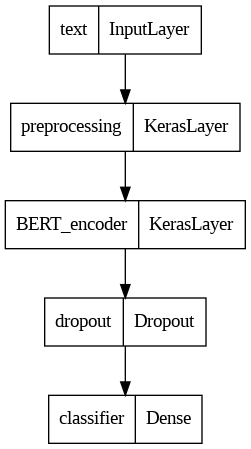

In [ ]:
tf.keras.utils.plot_model(classifier_model)

Questa istruzione genererà un diagramma del modello classifier_model che mostrerà la struttura del modello con i vari strati e le connessioni tra di essi.

## Model training

Ora disponi di tutti gli elementi per addestrare un modello, inclusi il modulo di preelaborazione, il codificatore BERT, i dati e il classificatore.

### Calcolo della funzione di perdita

Poiché si tratta di un problema di classificazione binaria e il modello restituisce una probabilità (uno strato a unità singola), utilizzerai la funzione di perdita di loss.BinaryCrossentropy.

In [ ]:
# Definizione della funzione di loss come Binary Cross Entropy con from_logits=True
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Definizione della metrica di valutazione come Binary Accuracy
metrics = tf.metrics.BinaryAccuracy()

1.   Binary Cross Entropy Loss: La funzione di loss BinaryCrossentropy viene definita con from_logits=True, indicando che gli output del modello sono logits e non probabilità. Questa loss è comunemente utilizzata per problemi di classificazione binaria.
2.   Binary Accuracy Metric: La metrica di valutazione BinaryAccuracy viene definita per calcolare l'accuratezza della classificazione binaria. Questa metrica misura la percentuale di previsioni corrette rispetto alle etichette di classe binarie


### Ottimizzatore

Per il fine-tuning, utilizzeremo lo stesso ottimizzatore con cui è stato originariamente addestrato BERT: l'ottimizzatore "Adaptive Moments" (Adam). Questo ottimizzatore minimizza la perdita di previsione e applica la regolarizzazione tramite decadimento dei pesi (senza utilizzare i momenti), noto anche come [AdamW](https://arxiv.org/abs/1711.05101).

Per il tasso di apprendimento (`init_lr`), utilizzeremo lo stesso schema di BERT durante la pre-elaborazione: decadimento lineare di un tasso di apprendimento iniziale ipotetico, preceduto da una fase di riscaldamento lineare nei primi 10% dei passaggi di addestramento (`num_warmup_steps`). In linea con il paper su BERT, il tasso di apprendimento iniziale è più basso per il fine-tuning (migliore tra 5e-5, 3e-5, 2e-5).

In [ ]:
# Definizione del numero di epoche per l'addestramento
epochs = 2

# Calcolo del numero di passaggi per epoca utilizzando la cardinalità del dataset di addestramento
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()

# Calcolo del numero totale di passaggi di addestramento
num_train_steps = steps_per_epoch * epochs

# Calcolo del numero di passaggi di riscaldamento (warmup steps)
num_warmup_steps = int(0.1 * num_train_steps)

# Inizializzazione del tasso di apprendimento (learning rate)
init_lr = 3e-5

# Creazione dell'ottimizzatore utilizzando l'ottimizzatore AdamW e i parametri specificati
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


1. **Definizione delle Epoche**: Viene definito il numero di epoche per l'addestramento del modello.
   
2. **Calcolo dei Passaggi per Epoca**: Viene calcolato il numero di passaggi (batches) per ogni epoca utilizzando la cardinalità del dataset di addestramento.
   
3. **Calcolo dei Passaggi Totali di Addestramento**: Viene calcolato il numero totale di passaggi di addestramento moltiplicando i passaggi per epoca per il numero di epoche.
   
4. **Calcolo dei Passaggi di Riscaldamento**: Viene calcolato il numero di passaggi di riscaldamento (warmup steps) come il 10% dei passaggi totali.
   
5. **Inizializzazione del Tasso di Apprendimento**: Viene inizializzato il tasso di apprendimento a 3e-5.
   
6. **Creazione dell'Ottimizzatore**: Viene creato un ottimizzatore utilizzando l'ottimizzatore AdamW con i parametri iniziali specificati, come il tasso di apprendimento iniziale, il numero totale di passaggi e i passaggi di riscaldamento.


### Caricamento del modello BERT e addestramento

Utilizzando il `classifier_model` creato in precedenza, puoi compilare il modello con la perdita, la metrica e l'ottimizzatore.

In [ ]:
# Configurazione del modello per l'addestramento
classifier_model.compile(optimizer=optimizer,  # Specifica dell'ottimizzatore
                         loss=loss,  # Specifica della funzione di loss
                         metrics=metrics)  # Specifica delle metriche da monitorare durante l'addestramento


Il tempo di formazione varierà a seconda della complessità del modello BERT selezionato.

In [ ]:
# Stampa dell'informazione relativa al modello BERT utilizzato per l'addestramento
print(f'Training model with {tfhub_handle_encoder}')

# Addestramento del modello utilizzando i dati di addestramento e di validazione
history = classifier_model.fit(x=train_ds,  # Dati di addestramento
                               validation_data=val_ds,  # Dati di validazione
                               epochs=epochs)  # Numero di epoche per l'addestramento


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
 13/625 [..............................] - ETA: 1:39:29 - loss: 0.7623 - binary_accuracy: 0.5048

## Addestramento del Modello:
Il modello viene addestrato utilizzando i dati di addestramento train_ds e i dati di validazione val_ds per il numero specificato di epoche epochs. Durante l'addestramento, il modello utilizzerà l'ottimizzatore configurato, la funzione di loss e le metriche specificate per migliorare le prestazioni sulla task di classificazione binaria

### Valuta il modello

Vediamo come si comporta il modello. Verranno restituiti due valori. Perdita (un numero che rappresenta l'errore, i valori più bassi sono migliori) e accuratezza.

In [ ]:
# Valutazione delle prestazioni del modello sui dati di test
loss, accuracy = classifier_model.evaluate(test_ds)

# Stampa della loss e dell'accuratezza ottenute durante la valutazione
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

### Plot the accuracy and loss over time

Basato sull'oggetto "History" restituito da "model.fit()". È possibile tracciare la perdita di addestramento e convalida per il confronto, nonché l'accuratezza dell'addestramento e della convalida:

In [ ]:
# Estrazione delle metriche di addestramento e validazione dalla history del modello
history_dict = history.history

# Estrazione delle chiavi disponibili nella history (metriche)
print(history_dict.keys())

# Estrazione di loss e accuratezza per addestramento e validazione
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Creazione della sequenza di epoche per il plot
epochs = range(1, len(acc) + 1)

# Creazione della figura per il plot
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

# Plot della loss per addestramento e validazione
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

# Plot dell'accuratezza per addestramento e validazione
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In questo grafico, le linee rosse rappresentano la perdita e l'accuratezza dell'addestramento, mentre le linee blu rappresentano la perdita e l'accuratezza della convalida.

Salvataggio del modello

In [ ]:
# Definizione del nome del dataset e del percorso per salvare il modello
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

# Salvataggio del modello addestrato nel percorso specificato
classifier_model.save(saved_model_path, include_optimizer=False)


In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

### Testing del modello

In [ ]:
def print_my_examples(inputs, results):
    # Creazione di una lista formattata per stampare gli input e i risultati
    result_for_printing = [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                           for i in range(len(inputs))]
    # Stampa dei risultati formattati
    print(*result_for_printing, sep='\n')
    print()

# Esempi di frasi da valutare
examples = [
    'this is such an amazing movie!',  # stessa frase provata in precedenza
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

# Valutazione dei risultati utilizzando il modello ricaricato e il modello originale
reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

# Stampa dei risultati ottenuti dal modello salvato
print('Results from the saved model:')
print_my_examples(examples, reloaded_results)

# Stampa dei risultati ottenuti dal modello in memoria
print('Results from the model in memory:')
print_my_examples(examples, original_results)


Questo codice valuta una serie di esempi di frasi utilizzando due modelli diversi: uno caricato da un modello salvato (reloaded_model) e l'altro presente in memoria (classifier_model). I risultati vengono confrontati e stampati per mostrare le previsioni generate dai due modelli su ciascuna frase di esempio.

Se desideri utilizzare il tuo modello su [TF Serving](https://www.tensorflow.org/tfx/guide/serving), ricorda che chiamerà il tuo SavedModel tramite una delle sue firme denominate. In Python, puoi testarli come segue:

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

Valutazione sui dati di test

In [ ]:
def recognize_entities(text, result, tokenizer):
    # Estrai le etichette predette dal risultato del modello
    predicted_labels = tf.math.argmax(result, axis=-1).numpy()[0]
    # Converti gli ID delle etichette in etichette leggibili
    labels = [classifier_model.config.id2label[label_id] for label_id in predicted_labels]
    # Estrai i token dal tokenizer
    tokens = tokenizer.tokenize(text)

    # Inizializza una lista per memorizzare le entità riconosciute
    recognized_entities = []
    # Variabile per memorizzare l'entità corrente mentre viene costruita
    current_entity = {"text": "", "label": None}

    # Itera sui token e sulle relative etichette predette
    for token, label in zip(tokens, labels):
        # Se l'etichetta inizia con 'B-', inizia una nuova entità
        if label.startswith('B-'):
            # Se c'è un'entità corrente, aggiungila alla lista
            if current_entity["text"]:
                recognized_entities.append(current_entity)
            # Inizia una nuova entità con il token corrente e l'etichetta
            current_entity = {"text": token, "label": label[2:]}
        # Se l'etichetta inizia con 'I-', aggiungi il token all'entità corrente
        elif label.startswith('I-'):
            current_entity["text"] += " " + token
        # Se l'etichetta non è né 'B-' né 'I-', controlla se c'è un'entità corrente
        # e aggiungila alla lista se presente
        else:
            if current_entity["text"]:
                recognized_entities.append(current_entity)
                current_entity = {"text": "", "label": None}

    # Aggiungi l'ultima entità corrente alla lista se presente
    if current_entity["text"]:
        recognized_entities.append(current_entity)

    return recognized_entities


Dati di test vs Dati di Train

In [ ]:
# Valutazione del modello sui dati di test
test_loss, test_accuracy = classifier_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Valutazione del modello sui dati di addestramento
train_loss, train_accuracy = classifier_model.evaluate(train_ds)
print(f'Training Loss: {train_loss}')
print(f'Training Accuracy: {train_accuracy}')


583/782 [=====================>........] - ETA: 4:24 - loss: 0.9579 - binary_accuracy: 0.4997

Sentiment Analisys

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import re
from nltk.corpus import stopwords

def analyze_sentiment(text):
    # Preprocess the input text
    processed_tweet = re.sub(r'\W', ' ', str(text))
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet)
    processed_tweet = re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    processed_tweet = processed_tweet.lower()

    # Create a TF-IDF vectorizer
    tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))

    # Transform the preprocessed text into a TF-IDF array
    X = tfidfconverter.fit_transform([processed_tweet]).toarray()

    # Load the trained model
    text_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

    # Predict the sentiment of the text
    prediction = text_classifier.predict(X)

    # Return the sentiment prediction (positive or negative)
    return "Positive" if prediction == 1 else "Negative"

# Esempio di utilizzo della funzione per analizzare il sentiment di un testo
text_example = "This movie is fantastic!"
sentiment_result = analyze_sentiment(text_example)
print(f"The sentiment of the text '{text_example}' is: {sentiment_result}")
